# Подбор модели и гипперпараметров к ней

In [1]:
from python_files.data import data
data_ = data.copy()
from python_files.elasticity.ela_col_list import ela_x_col_list, ela_col_list_norm, ela_col_list_std
from python_files.elasticity.ela_outliers import X_train, X_test, y_train, y_test

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [3]:
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, StandardScaler

## 1. Предобработка данных

Выполним нормализацию и стандартизацию данных перед подачей на модели. Выбросы в данных обрабатывать не будем. В препроцессоре будем нормализовывать и стандартизировать признаки с исходным распределением близким к нормальному и только стандартизировать признаки в которых исходное распределение отличается от нормального, т.е. попробуем сохранить исходные закономерности распределения величин в признаках.

In [4]:
# создадим препроцессор, который нормализует и стандартизирует данные
ela_preprocessor = ColumnTransformer(
    transformers=[
        ('normalization', PowerTransformer(), ela_col_list_norm), 
        ('scaling', StandardScaler(), ela_col_list_std) 
    ])

In [5]:
# нормализуем и стандартизируем
X_train_proc = ela_preprocessor.fit_transform(X_train)
X_train_proc = pd.DataFrame(data = X_train_proc, columns = ela_x_col_list)

In [6]:
# посмотрим что получили
X_train_proc.describe()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
count,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02
mean,4.614558e-16,-9.849353e-16,1.538186e-16,-9.923781e-17,3.771037e-16,6.400839e-16,-1.002302e-15,2.505755e-16,-1.538186e-16,1.339710e-16,2.480945e-17,1.736662e-17
std,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00
min,-2.795399e+00,-3.315188e+00,-2.499446e+00,-3.107488e+00,-3.336638e+00,-4.033827e+00,-2.879231e+00,-2.919919e+00,-2.872446e+00,-3.521669e+00,-1.694802e+00,-9.509234e-01
25%,-6.774696e-01,-6.819911e-01,-7.012970e-01,-6.498695e-01,-6.554573e-01,-6.708632e-01,-6.869632e-01,-6.544999e-01,-7.138652e-01,-6.247278e-01,-7.538111e-01,-9.509234e-01
50%,-5.449606e-03,6.003169e-02,6.271705e-02,-1.396741e-02,2.268079e-02,-1.127425e-02,6.090268e-03,2.973862e-02,1.974265e-02,-2.830320e-02,-1.229207e-01,-9.509234e-01
75%,6.969612e-01,6.328932e-01,7.033977e-01,6.570965e-01,7.072717e-01,6.544604e-01,6.301709e-01,6.671943e-01,6.777051e-01,6.337152e-01,7.364751e-01,1.051609e+00
max,2.472931e+00,3.054018e+00,3.220805e+00,3.219462e+00,4.283174e+00,2.965476e+00,2.735441e+00,3.119044e+00,2.943353e+00,4.246995e+00,3.188903e+00,1.051609e+00


In [7]:
# нормализуем и стандартизируем
X_test_proc = ela_preprocessor.fit_transform(X_test)
X_test_proc = pd.DataFrame(data = X_test_proc, columns = ela_x_col_list)

In [8]:
# посмотрим что получили
X_test_proc.describe()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
count,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02
mean,-1.186167e-16,-1.735854e-16,-3.876740e-16,8.823922e-17,-1.197739e-15,1.955728e-15,4.281772e-16,1.822646e-16,3.529569e-16,8.505683e-16,1.562268e-16,-2.314471e-17
std,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00
min,-3.083922e+00,-3.339712e+00,-2.610324e+00,-2.376389e+00,-2.578746e+00,-2.718387e+00,-2.766236e+00,-2.844819e+00,-2.819744e+00,-2.821342e+00,-1.754746e+00,-1.063929e+00
25%,-6.424146e-01,-7.127235e-01,-6.312770e-01,-6.581292e-01,-7.303454e-01,-6.517812e-01,-6.522449e-01,-6.438238e-01,-6.503528e-01,-5.809343e-01,-8.137726e-01,-1.063929e+00
50%,-4.588991e-03,-2.221703e-02,3.477098e-02,-1.796052e-02,-1.377916e-02,-1.066009e-02,-1.591883e-02,-3.731267e-02,2.665018e-03,5.439046e-03,-8.533846e-02,9.399125e-01
75%,6.508900e-01,6.317405e-01,6.770494e-01,6.951754e-01,7.548550e-01,6.689175e-01,6.203499e-01,6.749012e-01,6.274640e-01,6.023652e-01,7.443407e-01,9.399125e-01
max,2.956169e+00,2.899322e+00,3.091667e+00,3.016813e+00,2.604862e+00,3.043473e+00,2.686237e+00,2.542481e+00,2.509156e+00,3.426850e+00,2.803876e+00,9.399125e-01


In [9]:
# отдельно от 'Х_train' выборки нормализуем и стандартизируем 'y_train'
pt_y_train = PowerTransformer()
y_train = y_train.values.reshape(-1, 1)
y_train_proc = pt_y_train.fit_transform(y_train)
y_train_proc = pd.DataFrame(data = y_train_proc, columns = ['Модуль упругости при растяжении, ГПа'])
y_train_proc.describe()

,"Модуль упругости при растяжении, ГПа"
count,7.160000e+02
mean,1.488071e-14
std,1.000699e+00
min,-3.142326e+00
25%,-6.833687e-01
50%,1.319726e-02
75%,6.778916e-01
max,2.755187e+00


In [10]:
# отдельно от 'Х_test' выборки нормализуем и стандартизируем 'y_test'
pt_y_test = PowerTransformer()
y_test = y_test.values.reshape(-1, 1)
y_test_proc = pt_y_test.fit_transform(y_test)
y_test_proc = pd.DataFrame(data = y_test_proc, columns = ['Модуль упругости при растяжении, ГПа'])
y_test_proc.describe()

,"Модуль упругости при растяжении, ГПа"
count,3.070000e+02
mean,6.243287e-15
std,1.001633e+00
min,-2.691937e+00
25%,-6.056293e-01
50%,-5.161639e-02
75%,6.518408e-01
max,2.921044e+00


## 2. Подбор лучшей модели и ее гипперпараметров

   Проверим следующие модели:
- LinearRegression
- Lasso
- ElasticNet
- Ridge
- SVR
- KNeighborsRegressor
- DecisionTreeRegressor
- GradientBoostingRegressor
- RandomForestRegressor

 Выберем лучшую из них. Оценивать качество моделей будем по метрикам: mean_absolute_error, mean_squared_error и r2_score.

#### 2.1 Линейная регрессия

In [11]:
# Подбираем параметры fit_intercept(default=True), if set to False data is expected to be centered, и 
# positive(по умолчанию = False), который обращает коэффициенты модели в положительные при True
inter_cept = [True, False]
pos_lin_reg = [True, False]
lin_reg_tuned_parameters = [{'fit_intercept' : inter_cept,
                            'positive': pos_lin_reg}]

In [12]:
%%time
# обучаем модель
lin_reg_tuned = GridSearchCV(LinearRegression(), lin_reg_tuned_parameters, cv=10, scoring='r2')
lin_reg_tuned.fit(X_train_proc, y_train_proc)

CPU times: total: 1.05 s
Wall time: 2.89 s


GridSearchCV(cv=10, estimator=LinearRegression(),
             param_grid=[{'fit_intercept': [True, False],
                          'positive': [True, False]}],
             scoring='r2')

In [13]:
# выводим результат
lin_reg_tuned.best_params_

{'fit_intercept': False, 'positive': True}

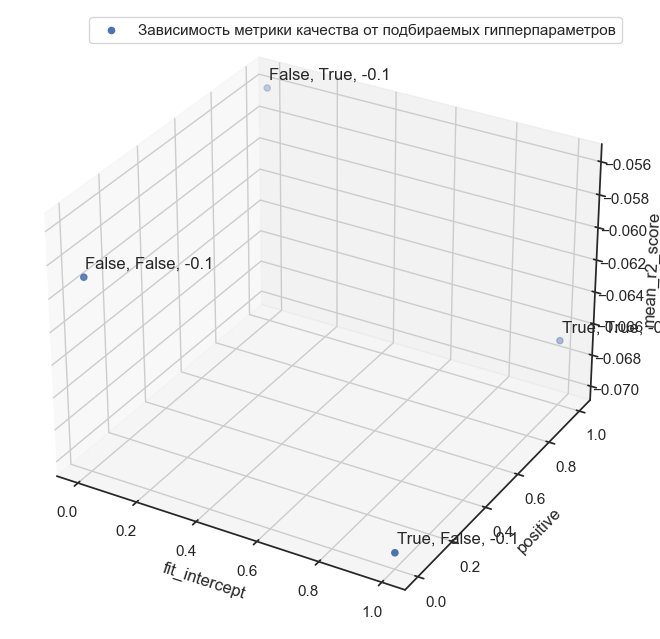

In [14]:
# прокладываем график зависимости метрики качества от подбираемых гипперпараметров
x_list = []
y_list = []
for i in range(4):
    x, y = lin_reg_tuned.cv_results_['params'][i].values()
    x_list.append(x)
    y_list.append(y)

ax = plt.figure(figsize=(8,10)).add_subplot(projection='3d')
ax.scatter(x_list, y_list, lin_reg_tuned.cv_results_['mean_test_score'], label='Зависимость метрики качества от подбираемых гипперпараметров')
for i, j, k in zip(x_list, y_list, lin_reg_tuned.cv_results_['mean_test_score']):
    text = str(i) + ', ' + str(j) + ', ' + str(round(k, 1))
    ax.text(i, j+0.01, k+0.0005, text)
plt.xlabel('fit_intercept')
plt.ylabel('positive')
ax.set_zlabel('mean_r2_score')
ax.legend()
plt.show()

In [15]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров
lin_reg_tuned.best_estimator_.fit(X_train_proc, y_train_proc)
lin_reg_tuned_predict_train_ = lin_reg_tuned.best_estimator_.predict(X_train_proc)
lin_reg_tuned_predict_test_ = lin_reg_tuned.best_estimator_.predict(X_test_proc)

In [16]:
# Качество модели по метрике r2_score после подбора гиперпараметров
r2_score(y_train_proc, lin_reg_tuned_predict_train_), r2_score(y_test_proc, lin_reg_tuned_predict_test_)

(0.012646106924068867, -0.007831876006708649)

In [17]:
# дестандартизация и денормализация предсказаных значений  
lin_reg_tuned_predict_train = pt_y_train.inverse_transform(lin_reg_tuned_predict_train_)
lin_reg_tuned_predict_test = pt_y_test.inverse_transform(lin_reg_tuned_predict_test_)

In [18]:
# Качество модели по метрике mean_squared_error после подбора гиперпараметров
mean_squared_error(y_train, lin_reg_tuned_predict_train), mean_squared_error(y_test, lin_reg_tuned_predict_test)

(9.828035027935249, 9.244717750951496)

In [19]:
# Качество модели по метрике mean_absolute_error после подбора гиперпараметров
mean_absolute_error(y_train, lin_reg_tuned_predict_train), mean_absolute_error(y_test, lin_reg_tuned_predict_test)

(2.509523246047192, 2.4428599067444035)

In [20]:
# Построение кривой обучения (зависимость качества модели от размера обучающей выборки)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring='r2'):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

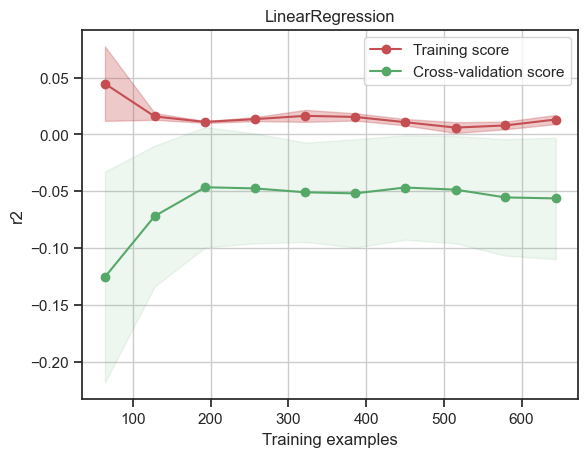

In [21]:
# Построение кривой обучения (зависимость качества модели от размера обучающей выборки)
plot_learning_curve(lin_reg_tuned.best_estimator_, 'LinearRegression', 
                    X_train_proc, y_train_proc, cv=10, train_sizes=np.linspace(.1, 1.0, 10))

In [22]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring='r2'):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(str(scoring))
    plt.ylim(0.5, -0.5) 
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.4,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

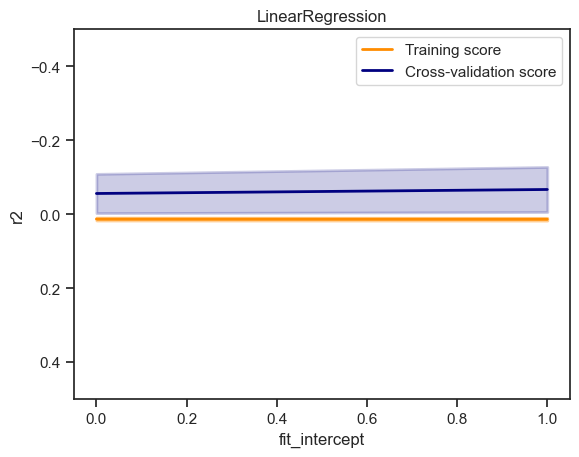

In [23]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(lin_reg_tuned.best_estimator_, 'LinearRegression', 
                      X_train_proc, y_train_proc, 
                      param_name='fit_intercept', param_range=inter_cept, 
                      cv=10, scoring="r2")

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

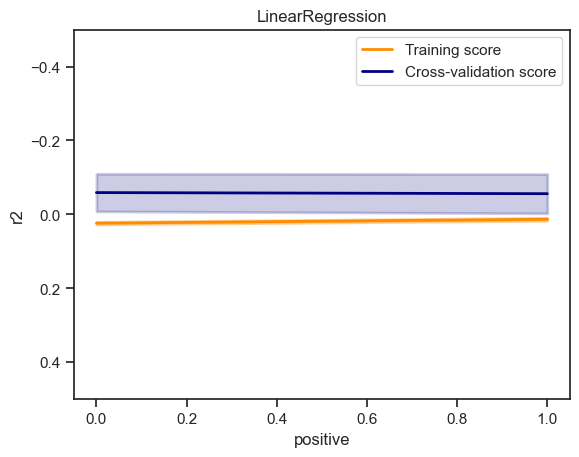

In [24]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(lin_reg_tuned.best_estimator_, 'LinearRegression', 
                      X_train_proc, y_train_proc, 
                      param_name='positive', param_range=pos_lin_reg, 
                      cv=10, scoring="r2")

#### 2.2 Регрессия Лассо 

In [25]:
# Подбираем параметр alpha(по умолчанию = 1.0), на который умножается "штраф" регуляризации L1, и 
# max_iter(default=1000), maximum number of iterations
alpha_lasso = [0.2, 0.4, 0.6, 0.8, 1.0, 2, 5, 10, 50, 100]
max_iter_lasso = [1000, 2000, 3000]
lasso_tuned_parameters = [{'alpha': alpha_lasso,
                          'max_iter' : max_iter_lasso}]

In [26]:
%%time
# обучаем модель
Lasso_tuned = GridSearchCV(Lasso(random_state = 7), lasso_tuned_parameters, cv=10, scoring='r2')
Lasso_tuned.fit(X_train_proc, y_train_proc)

CPU times: total: 2.38 s
Wall time: 2.63 s


GridSearchCV(cv=10, estimator=Lasso(random_state=7),
             param_grid=[{'alpha': [0.2, 0.4, 0.6, 0.8, 1.0, 2, 5, 10, 50, 100],
                          'max_iter': [1000, 2000, 3000]}],
             scoring='r2')

In [27]:
# выводим результат
Lasso_tuned.best_params_

{'alpha': 0.2, 'max_iter': 1000}

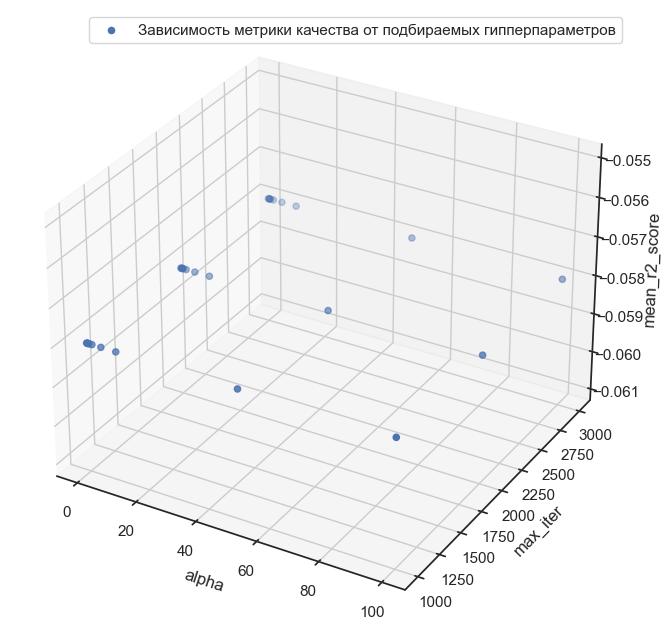

In [28]:
# прокладываем график зависимости метрики качества от подбираемых гипперпараметров
x_list = []
y_list = []
for i in range(30):
    x, y = Lasso_tuned.cv_results_['params'][i].values()
    x_list.append(x)
    y_list.append(y)

ax = plt.figure(figsize=(8,10)).add_subplot(projection='3d')
ax.scatter(x_list, y_list, Lasso_tuned.cv_results_['mean_test_score'], label='Зависимость метрики качества от подбираемых гипперпараметров')
plt.xlabel('alpha')
plt.ylabel('max_iter')
ax.set_zlabel('mean_r2_score')
ax.legend()
plt.show()

In [29]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров
Lasso_tuned.best_estimator_.fit(X_train_proc, y_train_proc)
Lasso_tuned_predict_train_ = Lasso_tuned.best_estimator_.predict(X_train_proc)
Lasso_tuned_predict_test_ = Lasso_tuned.best_estimator_.predict(X_test_proc)

In [30]:
# Качество модели по метрике r2_score после подбора гиперпараметров
r2_score(y_train_proc, Lasso_tuned_predict_train_), r2_score(y_test_proc, Lasso_tuned_predict_test_)

(0.0, 0.0)

In [31]:
Lasso_tuned_predict_train_ = Lasso_tuned_predict_train_.reshape(-1, 1)
Lasso_tuned_predict_test_ = Lasso_tuned_predict_test_.reshape(-1, 1)

In [32]:
# дестандартизация и денормализация предсказаных значений  
Lasso_tuned_predict_train = pt_y_train.inverse_transform(Lasso_tuned_predict_train_)
Lasso_tuned_predict_test = pt_y_test.inverse_transform(Lasso_tuned_predict_test_)

In [33]:
# Качество модели по метрике mean_squared_error после подбора гиперпараметров
mean_squared_error(y_train, Lasso_tuned_predict_train), mean_squared_error(y_test, Lasso_tuned_predict_test)

(9.953693257590718, 9.177601930191715)

In [34]:
# Качество модели по метрике mean_absolute_error после подбора гиперпараметров
mean_absolute_error(y_train, Lasso_tuned_predict_train), mean_absolute_error(y_test, Lasso_tuned_predict_test)

(2.5293950399201335, 2.436488520487601)

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

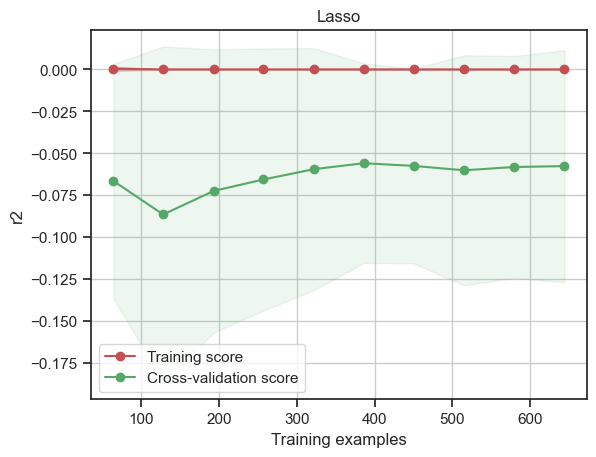

In [35]:
# Построение кривой обучения (зависимость качества модели от размера обучающей выборки)
plot_learning_curve(Lasso_tuned.best_estimator_, 'Lasso', 
                    X_train_proc, y_train_proc, cv=10, train_sizes=np.linspace(.1, 1.0, 10))

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

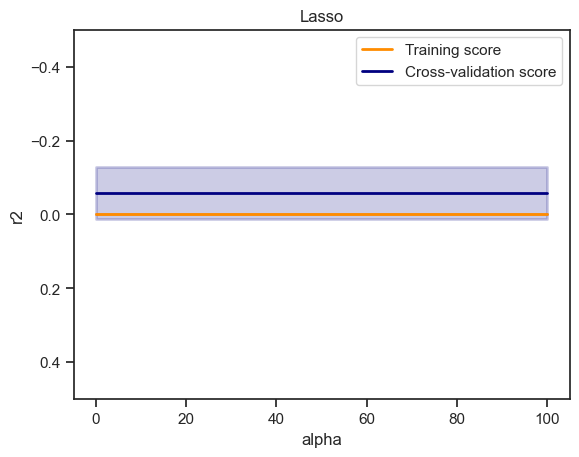

In [36]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(Lasso_tuned.best_estimator_, 'Lasso', 
                      X_train_proc, y_train_proc, 
                      param_name='alpha', param_range=alpha_lasso, 
                      cv=10, scoring="r2")

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

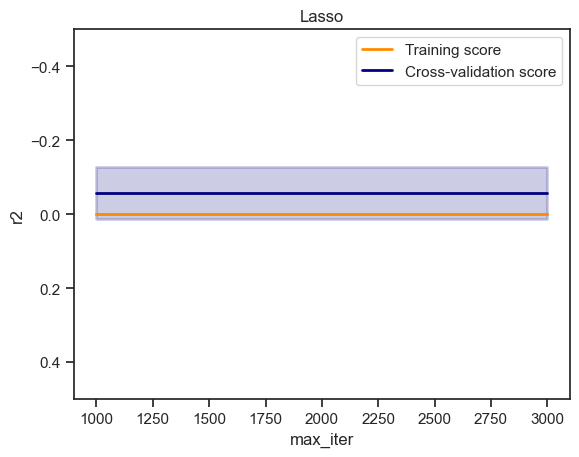

In [37]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(Lasso_tuned.best_estimator_, 'Lasso', 
                      X_train_proc, y_train_proc, 
                      param_name='max_iter', param_range=max_iter_lasso, 
                      cv=10, scoring="r2")

#### 2.3 Регрессор ElasticNet

In [38]:
# Подбираем параметр alpha(по умолчанию = 1.0), на который умножается "штраф" регуляризации L1, и параметр l1_ratio(по умолчанию = 0.5), который может
# принимать значения от 0 до 1 и отвечает за "штраф" комбинируя регуляризации L1 и L2(l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1.
# For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.) 
alpha_el_net = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
l1_ratio_el_net = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
el_net_tuned_parameters = [{'alpha' : alpha_el_net,
                            'l1_ratio' : l1_ratio_el_net}]

In [39]:
%%time
# обучаем модель
el_net_tuned = GridSearchCV(ElasticNet(random_state = 7), el_net_tuned_parameters, cv=10, scoring='r2')
el_net_tuned.fit(X_train_proc, y_train_proc)

CPU times: total: 7.62 s
Wall time: 7.67 s


GridSearchCV(cv=10, estimator=ElasticNet(random_state=7),
             param_grid=[{'alpha': [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8,
                                    2.0],
                          'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                       0.9, 1.0]}],
             scoring='r2')

In [40]:
# выводим результат
el_net_tuned.best_params_

{'alpha': 0.2, 'l1_ratio': 0.5}

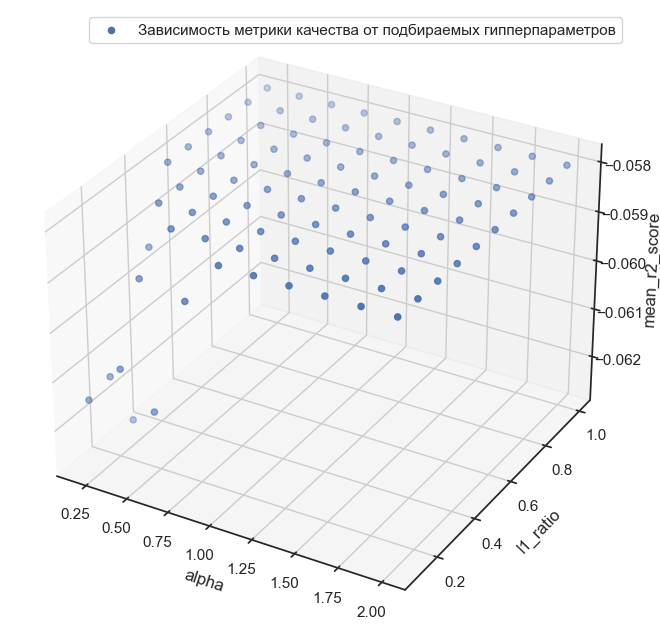

In [41]:
# прокладываем график зависимости метрики качества от подбираемых гипперпараметров
x_list = []
y_list = []
for i in range(100):
    x, y = el_net_tuned.cv_results_['params'][i].values()
    x_list.append(x)
    y_list.append(y)

ax = plt.figure(figsize=(8,10)).add_subplot(projection='3d')
ax.scatter(x_list, y_list, el_net_tuned.cv_results_['mean_test_score'], label='Зависимость метрики качества от подбираемых гипперпараметров')
plt.xlabel('alpha')
plt.ylabel('l1_ratio')
ax.set_zlabel('mean_r2_score')
ax.legend()
plt.show()

In [42]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров
el_net_tuned.best_estimator_.fit(X_train_proc, y_train_proc)
el_net_predict_train_ = el_net_tuned.best_estimator_.predict(X_train_proc)
el_net_predict_test_ = el_net_tuned.best_estimator_.predict(X_test_proc)

In [43]:
# Качество модели по метрике r2_score после подбора гиперпараметров
r2_score(y_train_proc, el_net_predict_train_), r2_score(y_test_proc, el_net_predict_test_)

(0.0, 0.0)

In [44]:
el_net_predict_train_ = el_net_predict_train_.reshape(-1, 1)
el_net_predict_test_ = el_net_predict_test_.reshape(-1, 1)

In [45]:
# дестандартизация и денормализация предсказаных значений  
el_net_predict_train = pt_y_train.inverse_transform(el_net_predict_train_)
el_net_predict_test = pt_y_test.inverse_transform(el_net_predict_test_) 

In [46]:
# Качество модели по метрике mean_squared_error после подбора гиперпараметров
mean_squared_error(y_train, el_net_predict_train), mean_squared_error(y_test, el_net_predict_test)

(9.953693257590718, 9.177601930191715)

In [47]:
# Качество модели по метрике mean_absolute_error после подбора гиперпараметров
mean_absolute_error(y_train, el_net_predict_train), mean_absolute_error(y_test, el_net_predict_test)

(2.5293950399201335, 2.436488520487601)

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

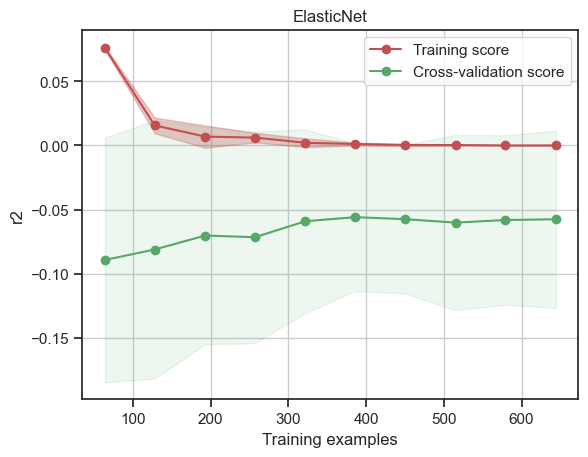

In [48]:
# Построение кривой обучения (зависимость качества модели от размера обучающей выборки)
plot_learning_curve(el_net_tuned.best_estimator_, 'ElasticNet', 
                    X_train_proc, y_train_proc, cv=10, train_sizes=np.linspace(.1, 1.0, 10))

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

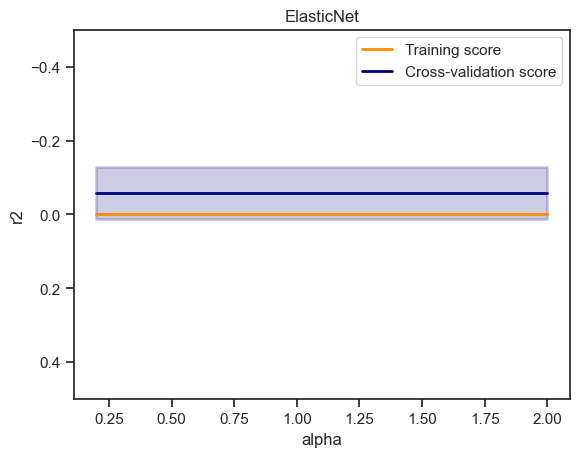

In [49]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(el_net_tuned.best_estimator_, 'ElasticNet', 
                      X_train_proc, y_train_proc, 
                      param_name='alpha', param_range=alpha_el_net, 
                      cv=10, scoring="r2")

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

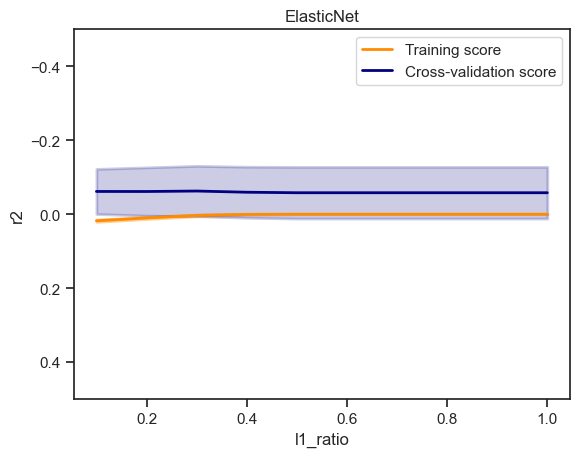

In [50]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(el_net_tuned.best_estimator_, 'ElasticNet', 
                      X_train_proc, y_train_proc, 
                      param_name='l1_ratio', param_range=l1_ratio_el_net, 
                      cv=10, scoring="r2")

#### 2.4 Регрессор Ridge

In [51]:
# Подбираем параметры alpha(по умолчанию = 1.0) - Constant that multiplies the L2 term, controlling regularization strength,
# alpha must be a non-negative float i.e. in [0, inf); и
# positive(default=False), when set to True, forces the coefficients to be positive. Only ‘lbfgs’ solver is supported in this case.
alpha_ridge = [1, 10, 100, 1000, 2136, 3000, 5000]
pos_ridge = [True, False]
ridge_tuned_parameters = [{'alpha' : alpha_ridge,
                          'positive' : pos_ridge}]

In [52]:
%%time
# обучаем модель
ridge_tuned = GridSearchCV(Ridge(random_state = 7), ridge_tuned_parameters, cv=10, scoring='r2')
ridge_tuned.fit(X_train_proc, y_train_proc)

CPU times: total: 1.23 s
Wall time: 1.66 s


GridSearchCV(cv=10, estimator=Ridge(random_state=7),
             param_grid=[{'alpha': [1, 10, 100, 1000, 2136, 3000, 5000],
                          'positive': [True, False]}],
             scoring='r2')

In [53]:
# выводим результат
ridge_tuned.best_params_

{'alpha': 2136, 'positive': False}

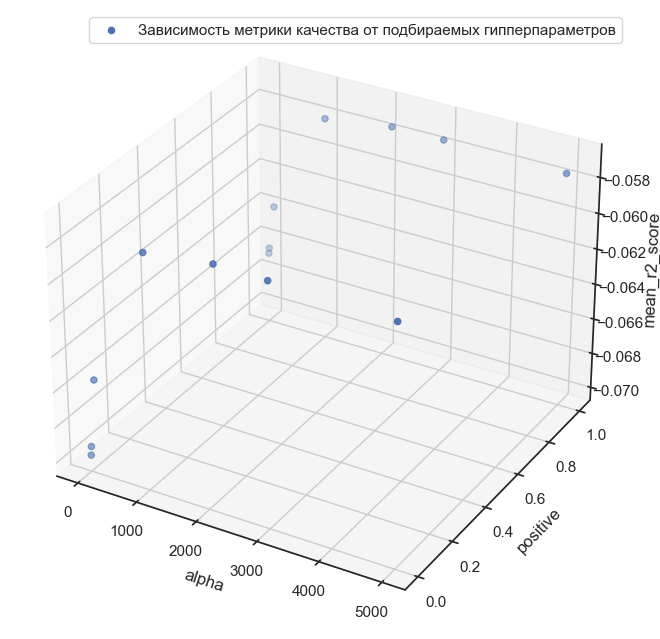

In [54]:
# прокладываем график зависимости метрики качества от подбираемых гипперпараметров
x_list = []
y_list = []
for i in range(14):
    x, y = ridge_tuned.cv_results_['params'][i].values()
    x_list.append(x)
    y_list.append(y)

ax = plt.figure(figsize=(8,10)).add_subplot(projection='3d')
ax.scatter(x_list, y_list, ridge_tuned.cv_results_['mean_test_score'], label='Зависимость метрики качества от подбираемых гипперпараметров')
plt.xlabel('alpha')
plt.ylabel('positive')
ax.set_zlabel('mean_r2_score')
ax.legend()
plt.show()

In [55]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров
ridge_tuned.best_estimator_.fit(X_train_proc, y_train_proc)
ridge_predict_train_ = ridge_tuned.best_estimator_.predict(X_train_proc)
ridge_predict_test_ = ridge_tuned.best_estimator_.predict(X_test_proc)

In [56]:
# Качество модели по метрике r2_score после подбора гиперпараметров
r2_score(y_train_proc, ridge_predict_train_), r2_score(y_test_proc, ridge_predict_test_)

(0.00913395101169634, -6.252684579588497e-05)

In [57]:
ridge_predict_train_ = ridge_predict_train_.reshape(-1, 1)
ridge_predict_test_ = ridge_predict_test_.reshape(-1, 1)

In [58]:
# дестандартизация и денормализация предсказаных значений  
ridge_predict_train = pt_y_train.inverse_transform(ridge_predict_train_)
ridge_predict_test = pt_y_test.inverse_transform(ridge_predict_test_)

In [59]:
# Качество модели по метрике mean_squared_error после подбора гиперпараметров
mean_squared_error(y_train, ridge_predict_train), mean_squared_error(y_test, ridge_predict_test)

(9.862851490581317, 9.17482876168959)

In [60]:
# Качество модели по метрике mean_absolute_error после подбора гиперпараметров
mean_absolute_error(y_train, ridge_predict_train), mean_absolute_error(y_test, ridge_predict_test)

(2.515328347568619, 2.437801173813977)

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

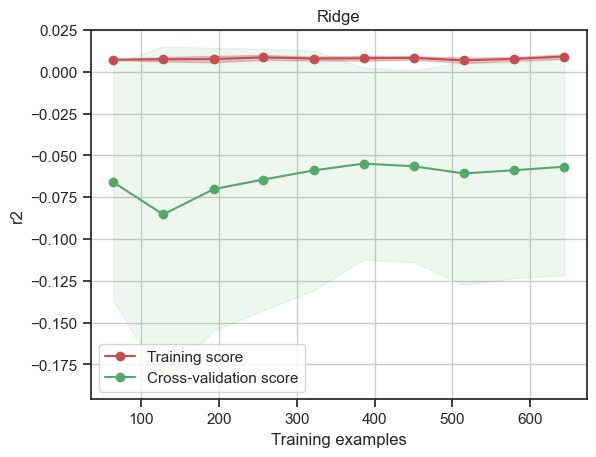

In [61]:
# Построение кривой обучения (зависимость качества модели от размера обучающей выборки)
plot_learning_curve(ridge_tuned.best_estimator_, 'Ridge', 
                    X_train_proc, y_train_proc, cv=10, train_sizes=np.linspace(.1, 1.0, 10))

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

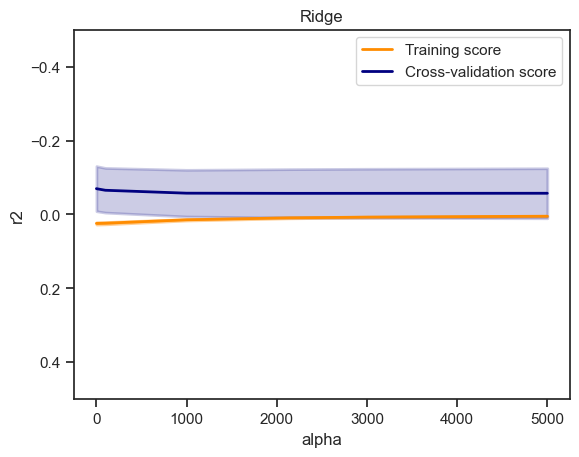

In [62]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(ridge_tuned.best_estimator_, 'Ridge', 
                      X_train_proc, y_train_proc, 
                      param_name='alpha', param_range = alpha_ridge, 
                      cv=10, scoring="r2")

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

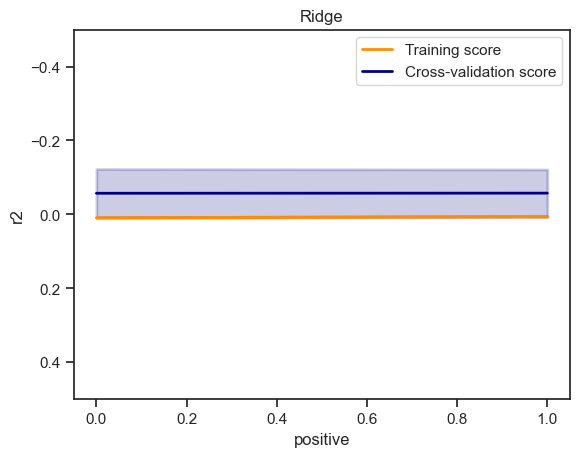

In [63]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(ridge_tuned.best_estimator_, 'Ridge', 
                      X_train_proc, y_train_proc, 
                      param_name='positive', param_range = pos_ridge, 
                      cv=10, scoring="r2")

#### 2.5 Машина опорных векторов (SVR) 

In [64]:
# подбираем параметры: 'kernel' - перебираем варианты ядра для модели (default=’rbf’),
# 'C' - регуляризация, сила регуляризации обратно пропрциональна 'C'(default=1.0), и
# 'gamma' - коэфф ядра для вариантов 'poly', 'rbf', 'sigmoid' (default=’scale’)
# ввиду ограниченности вычислительных мощностей сделаем это в два этапа
kernel_svr = ['linear', 'poly', 'rbf', 'sigmoid']
svr_tuned_parameters_1 = [{'kernel' : kernel_svr}]

In [65]:
%%time
# обучаем модель
y_train_proc_ = np.ravel(y_train_proc) 
svr_1 = GridSearchCV(SVR(), svr_tuned_parameters_1, cv=10, scoring='r2')
svr_1.fit(X_train_proc, y_train_proc_)

CPU times: total: 2.42 s
Wall time: 2.48 s


GridSearchCV(cv=10, estimator=SVR(),
             param_grid=[{'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             scoring='r2')

In [66]:
# выводим результат
svr_1.best_params_

{'kernel': 'linear'}

In [67]:
# как показал результат эксперимента выше, лучшим ядром модели для данной задачи (с остальными параметрами модели по умолчанию) является 'linear';
# подберем параметры 'C' и 'gamma' для этого ядра
C_svr = [0.2, 0.5, 1.0, 5, 10]
gamma_svr = ['scale', 'auto']
svr_tuned_parameters_2 = [{'C' : C_svr,
                         'gamma' : gamma_svr
                          }]

In [68]:
%%time
# обучаем модель
svr_2 = GridSearchCV(SVR(kernel = 'linear'), svr_tuned_parameters_2, cv=10, scoring='r2')
svr_2.fit(X_train_proc, y_train_proc_)

CPU times: total: 14.6 s
Wall time: 14.7 s


GridSearchCV(cv=10, estimator=SVR(kernel='linear'),
             param_grid=[{'C': [0.2, 0.5, 1.0, 5, 10],
                          'gamma': ['scale', 'auto']}],
             scoring='r2')

In [69]:
# выводим результат
svr_2.best_params_

{'C': 5, 'gamma': 'scale'}

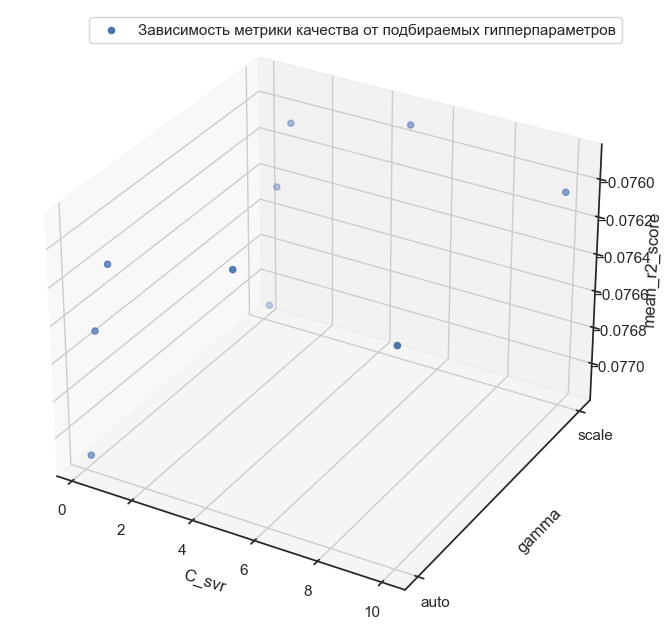

In [70]:
# прокладываем график зависимости метрики качества от подбираемых гипперпараметров
x_list = []
y_list = []

for i in range(10):
    x, y = svr_2.cv_results_['params'][i].values()
    
    x_list.append(x)
    y_list.append(y)
    
yy_list = LabelEncoder().fit_transform(y_list)

ax = plt.figure(figsize=(8,10)).add_subplot(projection='3d')
ax.scatter(x_list, yy_list, svr_2.cv_results_['mean_test_score'], label='Зависимость метрики качества от подбираемых гипперпараметров')

for i, j, k in zip(x_list, yy_list, svr_2.cv_results_['mean_test_score']):
    text = str(i) + ', ' + str(j) + ', ' + str(round(k, 2))
    ax.text(i, j+0.01, k+0.005, text)

plt.xlabel('С_svr')
plt.ylabel('gamma')
ax.set_yticks([0, 1])
ax.set_yticklabels(['auto', 'scale'])
ax.set_zlabel('mean_r2_score')
ax.legend()
plt.show()

In [71]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров
svr_2.best_estimator_.fit(X_train_proc, y_train_proc_)
svr_2_predict_train_ = svr_2.best_estimator_.predict(X_train_proc)
svr_2_predict_test_ = svr_2.best_estimator_.predict(X_test_proc)

In [72]:
# Качество модели по метрике r2_score после подбора гиперпараметров
r2_score(y_train_proc, svr_2_predict_train_), r2_score(y_test_proc, svr_2_predict_test_)

(0.013846695607285131, -0.051856412171235045)

In [73]:
svr_2_predict_train_ = svr_2_predict_train_.reshape(-1, 1)
svr_2_predict_test_ = svr_2_predict_test_.reshape(-1, 1)

In [74]:
# дестандартизация и денормализация предсказаных значений  
svr_2_predict_train = pt_y_train.inverse_transform(svr_2_predict_train_)
svr_2_predict_test = pt_y_test.inverse_transform(svr_2_predict_test_)

In [75]:
# Качество модели по метрике mean_squared_error после подбора гиперпараметров
mean_squared_error(y_train, svr_2_predict_train), mean_squared_error(y_test, svr_2_predict_test)

(9.804956465698972, 9.619020524718353)

In [76]:
# Качество модели по метрике mean_absolute_error после подбора гиперпараметров
mean_absolute_error(y_train, svr_2_predict_train), mean_absolute_error(y_test, svr_2_predict_test)

(2.4739534608859204, 2.4940100237742433)

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

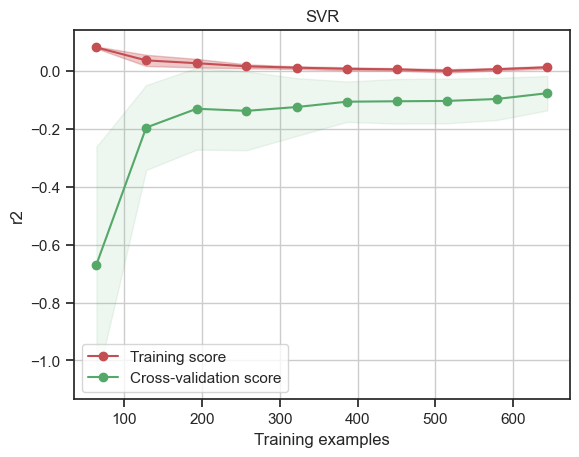

In [77]:
# Построение кривой обучения (зависимость качества модели от размера обучающей выборки)
plot_learning_curve(svr_2.best_estimator_, 'SVR', 
                    X_train_proc, y_train_proc_, cv=10, train_sizes=np.linspace(.1, 1.0, 10))

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

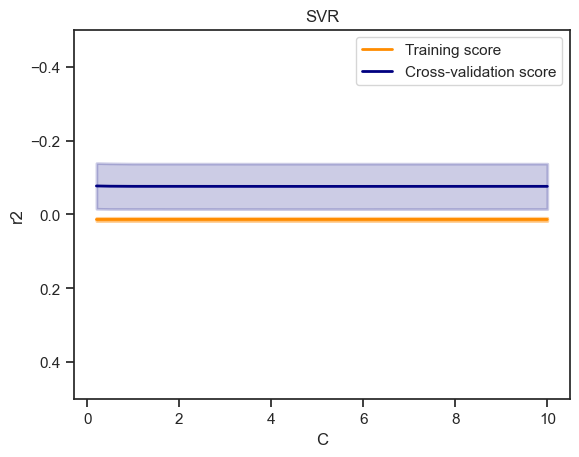

In [78]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(svr_2.best_estimator_, 'SVR', 
                      X_train_proc, y_train_proc_, 
                      param_name='C', param_range = C_svr, 
                      cv=10, scoring="r2")

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

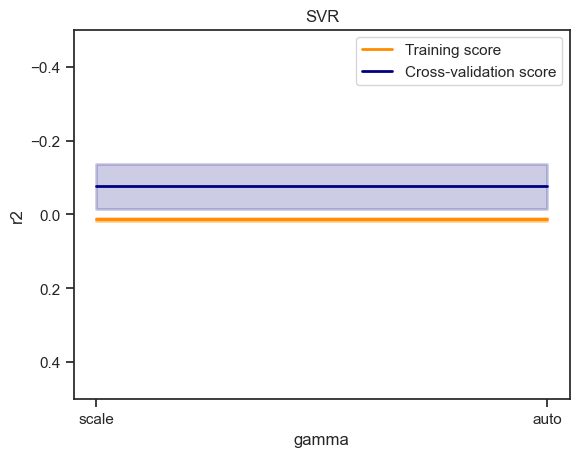

In [79]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(svr_2.best_estimator_, 'SVR', 
                      X_train_proc, y_train_proc_, 
                      param_name='gamma', param_range = gamma_svr, 
                      cv=10, scoring="r2")

#### 2.6 Метод ближайших соседей

In [80]:
# подбираем параметры: 'n_neighbors' - number of neighbors to use by default for kneighbors queries` (default=5); и 
# 'weights' - Weight function used in prediction (default=’uniform’)
n_neigh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
weights = ['uniform', 'distance']
knn_tuned_parameters = [{'n_neighbors' : n_neigh,
                         'weights' : weights
                        }]

In [81]:
%%time
# обучаем модель
knn = GridSearchCV(KNeighborsRegressor(), knn_tuned_parameters, cv=10, scoring='r2')
knn.fit(X_train_proc, y_train_proc)

CPU times: total: 2.11 s
Wall time: 2.33 s


GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'weights': ['uniform', 'distance']}],
             scoring='r2')

In [82]:
# выводим результат
knn.best_params_

{'n_neighbors': 10, 'weights': 'uniform'}

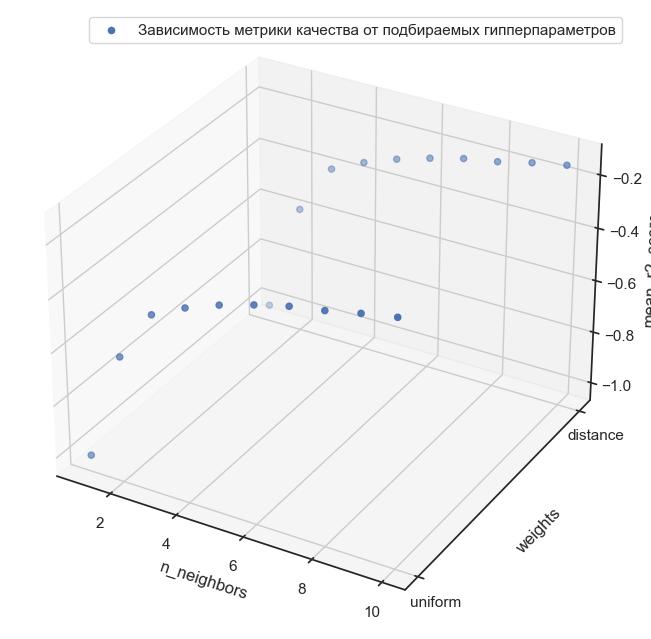

In [83]:
# прокладываем график зависимости метрики качества от подбираемых гипперпараметров
x_list = []
y_list = []

for i in range(20):
    x, y = knn.cv_results_['params'][i].values()
    
    x_list.append(x)
    y_list.append(y)
    
yy_list = LabelEncoder().fit_transform(y_list)

ax = plt.figure(figsize=(8,10)).add_subplot(projection='3d')
ax.scatter(x_list, yy_list, knn.cv_results_['mean_test_score'], label='Зависимость метрики качества от подбираемых гипперпараметров')

# for i, j, k in zip(x_list, yy_list, svr_2.cv_results_['mean_test_score']):
    # text = str(i) + ', ' + str(j) + ', ' + str(round(k, 2))
    # ax.text(i, j+0.01, k+0.005, text)

plt.xlabel('n_neighbors')
plt.ylabel('weights')
ax.set_yticks([0, 1])
ax.set_yticklabels(['uniform', 'distance'])
ax.set_zlabel('mean_r2_score')
ax.legend()
plt.show()

In [84]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров
knn.best_estimator_.fit(X_train_proc, y_train_proc)
knn_predict_train_ = knn.best_estimator_.predict(X_train_proc)
knn_predict_test_ = knn.best_estimator_.predict(X_test_proc)

In [85]:
# Качество модели по метрике r2_score после подбора гиперпараметров
r2_score(y_train_proc, knn_predict_train_), r2_score(y_test_proc, knn_predict_test_)

(0.08768110274871244, -0.15347993132807303)

In [86]:
knn_predict_train_ = knn_predict_train_.reshape(-1, 1)
knn_predict_test_ = knn_predict_test_.reshape(-1, 1)

In [87]:
# дестандартизация и денормализация предсказаных значений  
knn_predict_train = pt_y_train.inverse_transform(knn_predict_train_)
knn_predict_test = pt_y_test.inverse_transform(knn_predict_test_)

In [88]:
# Качество модели по метрике mean_squared_error после подбора гиперпараметров
mean_squared_error(y_train, knn_predict_train), mean_squared_error(y_test, knn_predict_test)

(9.089734472947587, 10.570755949521903)

In [89]:
# Качество модели по метрике mean_absolute_error после подбора гиперпараметров
mean_absolute_error(y_train, knn_predict_train), mean_absolute_error(y_test, knn_predict_test)

(2.4080480130691098, 2.5919904264528895)

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

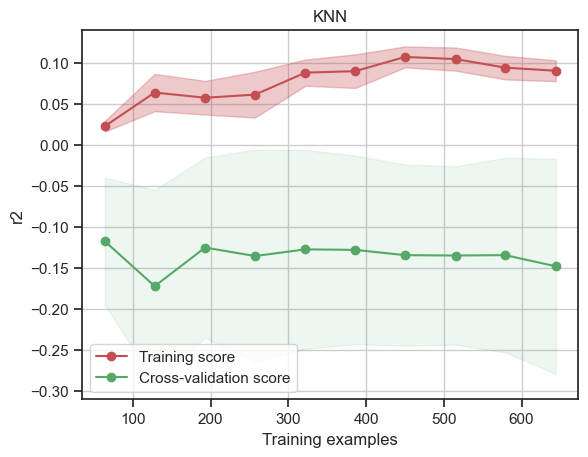

In [90]:
# Построение кривой обучения (зависимость качества модели от размера обучающей выборки)
plot_learning_curve(knn.best_estimator_, 'KNN', 
                    X_train_proc, y_train_proc, cv=10, train_sizes=np.linspace(.1, 1.0, 10))

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

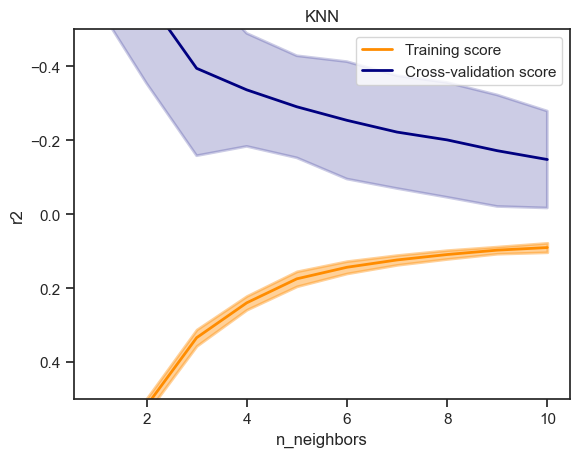

In [91]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(knn.best_estimator_, 'KNN', 
                      X_train_proc, y_train_proc, 
                      param_name='n_neighbors', param_range = n_neigh, 
                      cv=10, scoring="r2")

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

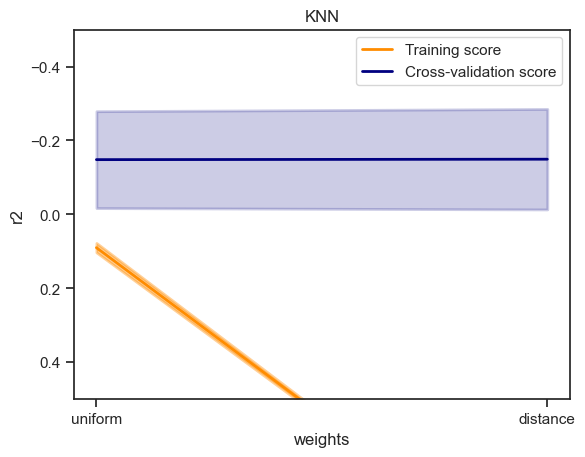

In [92]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(knn.best_estimator_, 'KNN', 
                      X_train_proc, y_train_proc, 
                      param_name='weights', param_range = weights, 
                      cv=10, scoring="r2")

#### 2.7 Решающее дерево

In [93]:
# подбираем параметры: 'criterion' - The function to measure the quality of a split (default=squared_error); и 
# 'min_samples_split' - The minimum number of samples required to split an internal node (default=2)
DT_criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
DT_min_samples_split = [2, 10, 345, 350, 355]
tree_tuned_parameters = [{'criterion' : DT_criterion,
                         'min_samples_split' : DT_min_samples_split
                        }]

In [94]:
%%time
# обучаем модель
tree = GridSearchCV(DecisionTreeRegressor(random_state = 7), tree_tuned_parameters, cv=10, scoring='r2')
tree.fit(X_train_proc, y_train)

CPU times: total: 3.92 s
Wall time: 4.02 s


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=7),
             param_grid=[{'criterion': ['squared_error', 'friedman_mse',
                                        'absolute_error', 'poisson'],
                          'min_samples_split': [2, 10, 345, 350, 355]}],
             scoring='r2')

In [95]:
# выводим результат
tree.best_params_

{'criterion': 'squared_error', 'min_samples_split': 350}

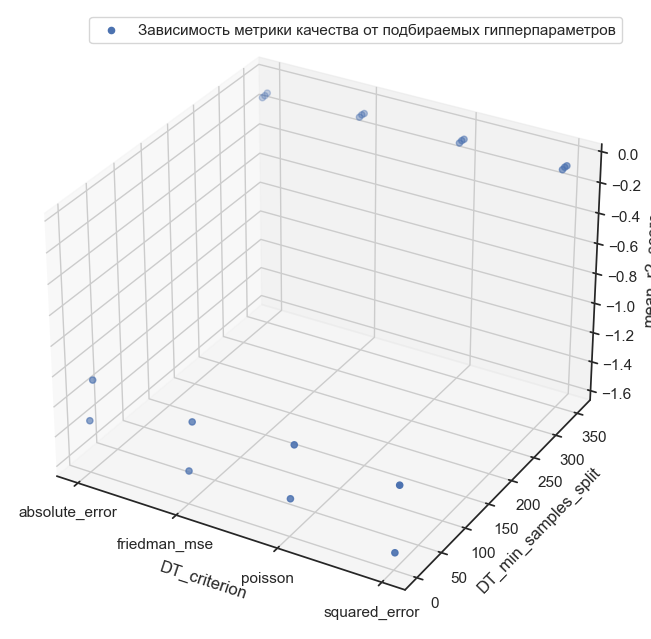

In [96]:
# прокладываем график зависимости метрики качества от подбираемых гипперпараметров
x_list = []
y_list = []

for i in range(20):
    x, y = tree.cv_results_['params'][i].values()
    
    x_list.append(x)
    y_list.append(y)
    
xx_list = LabelEncoder().fit_transform(x_list)

ax = plt.figure(figsize=(8,10)).add_subplot(projection='3d')
ax.scatter(xx_list, y_list, tree.cv_results_['mean_test_score'], label='Зависимость метрики качества от подбираемых гипперпараметров')

#for i, j, k in zip(xx_list, y_list, tree.cv_results_['mean_test_score']):
#    text = str(i) + ', ' + str(j) + ', ' + str(round(k, 1))
#    ax.text(i, j+0.01, k+0.005, text)

plt.xlabel('DT_criterion')
plt.ylabel('DT_min_samples_split')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['absolute_error', 'friedman_mse', 'poisson', 'squared_error'])
ax.set_zlabel('mean_r2_score')
ax.legend()
plt.show()

In [97]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров
tree.best_estimator_.fit(X_train_proc, y_train)
tree_predict_train = tree.best_estimator_.predict(X_train_proc)
tree_predict_test = tree.best_estimator_.predict(X_test_proc)

In [98]:
# Качество модели по метрике r2_score после подбора гиперпараметров
r2_score(y_train, tree_predict_train), r2_score(y_test, tree_predict_test)

(0.03079239574552184, -0.011901554756049038)

In [99]:
# Качество модели по метрике mean_squared_error после подбора гиперпараметров
mean_squared_error(y_train, tree_predict_train), mean_squared_error(y_test, tree_predict_test)

(9.64245730256717, 9.281067908125596)

In [100]:
# Качество модели по метрике mean_absolute_error после подбора гиперпараметров
mean_absolute_error(y_train, tree_predict_train), mean_absolute_error(y_test, tree_predict_test)

(2.4917820462565063, 2.4370112162211353)

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

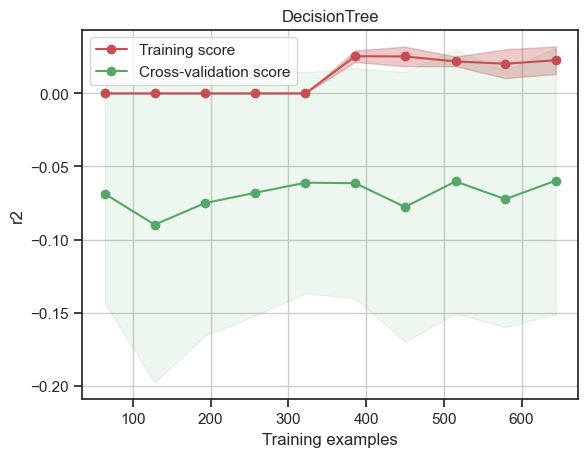

In [101]:
# Построение кривой обучения (зависимость качества модели от размера обучающей выборки)
plot_learning_curve(tree.best_estimator_, 'DecisionTree', 
                    X_train_proc, y_train, cv=10, train_sizes=np.linspace(.1, 1.0, 10))

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

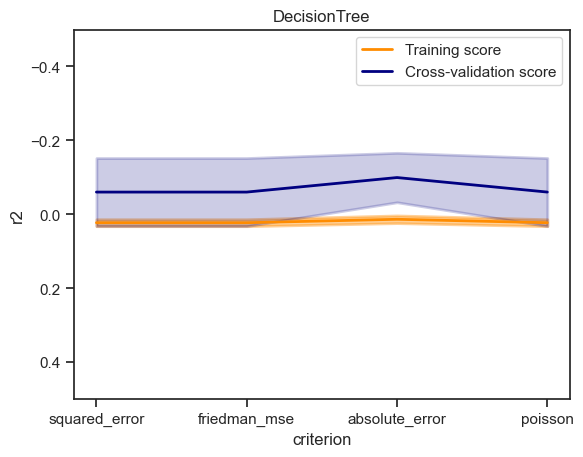

In [102]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(tree.best_estimator_, 'DecisionTree', 
                      X_train_proc, y_train, 
                      param_name='criterion', param_range = DT_criterion, 
                      cv=10, scoring="r2")

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

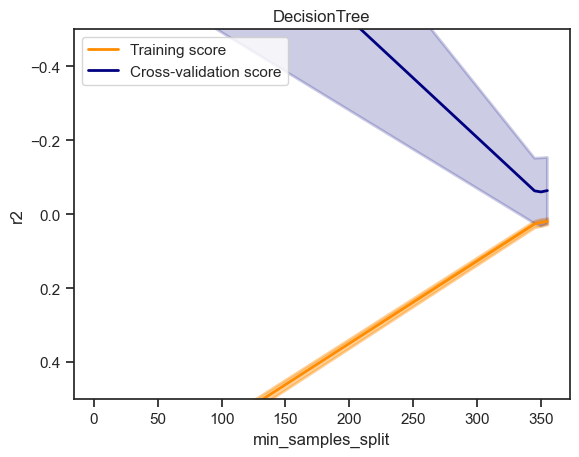

In [103]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(tree.best_estimator_, 'DecisionTree', 
                      X_train_proc, y_train, 
                      param_name='min_samples_split', param_range = DT_min_samples_split, 
                      cv=10, scoring="r2")

#### 2.8 Градиентный бустинг

In [104]:
# подбираем параметры: 'n_estimators' - the number of boosting stages to perform(default=100), и
# 'Learning rate' - shrinks the contribution of each tree by learning_rate(default=0.1).
GB_n_estimators = [100, 200, 300]
learning_rate = [0.01, 0.05, 0.1, 0.5, 1]
GB_tuned_parameters = [{'n_estimators' : GB_n_estimators,
                         'learning_rate' : learning_rate
                        }]

In [105]:
%%time
# обучаем модель
GB = GridSearchCV(GradientBoostingRegressor(random_state = 7), GB_tuned_parameters, cv=10, scoring='r2')
GB.fit(X_train_proc, y_train_proc_)

CPU times: total: 2min 31s
Wall time: 2min 32s


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=7),
             param_grid=[{'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
                          'n_estimators': [100, 200, 300]}],
             scoring='r2')

In [106]:
# выводим результат
GB.best_params_

{'learning_rate': 0.01, 'n_estimators': 100}

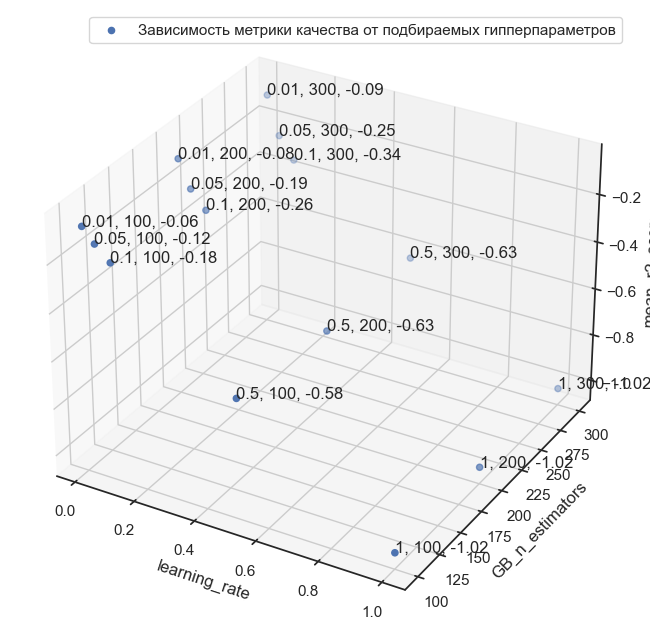

In [107]:
# прокладываем график зависимости метрики качества от подбираемых гипперпараметров
x_list = []
y_list = []

for i in range(15):
    x, y = GB.cv_results_['params'][i].values()
    
    x_list.append(x)
    y_list.append(y)

ax = plt.figure(figsize=(8,10)).add_subplot(projection='3d')
ax.scatter(x_list, y_list, GB.cv_results_['mean_test_score'], label='Зависимость метрики качества от подбираемых гипперпараметров')

for i, j, k in zip(x_list, y_list, GB.cv_results_['mean_test_score']):
    text = str(i) + ', ' + str(j) + ', ' + str(round(k, 2))
    ax.text(i, j+0.01, k+0.005, text)

plt.xlabel('learning_rate')
plt.ylabel('GB_n_estimators')
ax.set_zlabel('mean_r2_score')
ax.legend()
plt.show()

In [108]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров
GB.best_estimator_.fit(X_train_proc, y_train_proc_)
GB_predict_train_ = GB.best_estimator_.predict(X_train_proc)
GB_predict_test_ = GB.best_estimator_.predict(X_test_proc)

In [109]:
# Качество модели по метрике r2_score после подбора гиперпараметров
r2_score(y_train_proc, GB_predict_train_), r2_score(y_test_proc, GB_predict_test_)

(0.09135889925628937, 0.0003395050053651705)

In [110]:
GB_predict_train_ = GB_predict_train_.reshape(-1, 1)
GB_predict_test_ = GB_predict_test_.reshape(-1, 1)

In [111]:
# дестандартизация и денормализация предсказаных значений  
GB_predict_train = pt_y_train.inverse_transform(GB_predict_train_)
GB_predict_test = pt_y_test.inverse_transform(GB_predict_test_)

In [112]:
# Качество модели по метрике mean_squared_error после подбора гиперпараметров
mean_squared_error(y_train, GB_predict_train), mean_squared_error(y_test, GB_predict_test)

(9.050658974044199, 9.1722722574025)

In [113]:
# Качество модели по метрике mean_absolute_error после подбора гиперпараметров
mean_absolute_error(y_train, GB_predict_train), mean_absolute_error(y_test, GB_predict_test)

(2.4009448204598995, 2.4242367269924996)

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

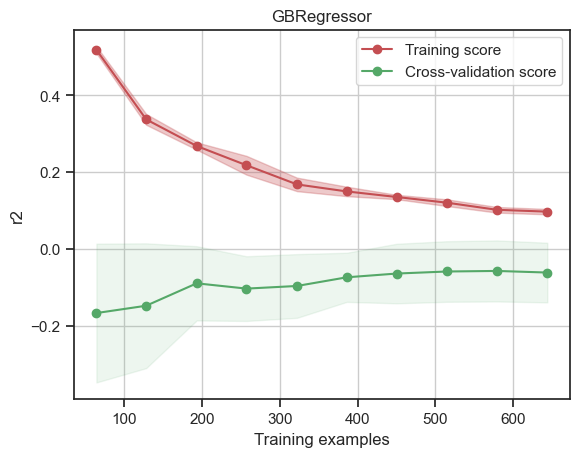

In [114]:
# Построение кривой обучения (зависимость качества модели от размера обучающей выборки)
plot_learning_curve(GB.best_estimator_, 'GBRegressor', 
                    X_train_proc, y_train_proc_, cv=10, train_sizes=np.linspace(.1, 1.0, 10))

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

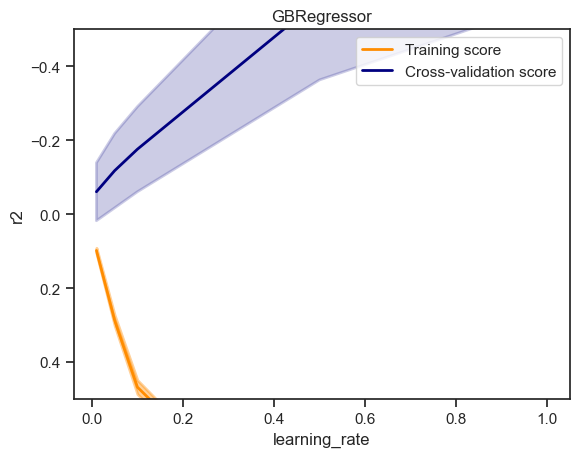

In [115]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(GB.best_estimator_, 'GBRegressor', 
                      X_train_proc, y_train_proc_, 
                      param_name='learning_rate', param_range = learning_rate, 
                      cv=10, scoring="r2")

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

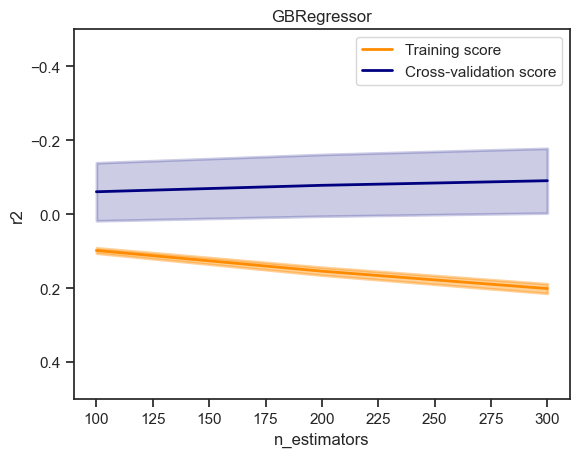

In [116]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(GB.best_estimator_, 'GBRegressor', 
                      X_train_proc, y_train_proc_, 
                      param_name='n_estimators', param_range = GB_n_estimators, 
                      cv=10, scoring="r2")

#### 2.9 Случайный лес

In [117]:
# подбираем параметры: 'n_estimators' - the number of boosting stages to perform(default=100), и
# 'min_samples_split' - minimum number of samples required to split an internal node(default=2).
RF_n_estimators = [100, 200, 300]
RF_min_samples_split = [2, 10, 50, 100, 300]
RF_tuned_parameters = [{'n_estimators' : RF_n_estimators,
                         'min_samples_split' : RF_min_samples_split
                        }]

In [118]:
%%time
# обучаем модель
RF = GridSearchCV(RandomForestRegressor(random_state = 7), RF_tuned_parameters, cv=10, scoring='r2')
RF.fit(X_train_proc, y_train_proc_)

CPU times: total: 4min 16s
Wall time: 4min 18s


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=7),
             param_grid=[{'min_samples_split': [2, 10, 50, 100, 300],
                          'n_estimators': [100, 200, 300]}],
             scoring='r2')

In [119]:
# выводим результат
RF.best_params_

{'min_samples_split': 300, 'n_estimators': 300}

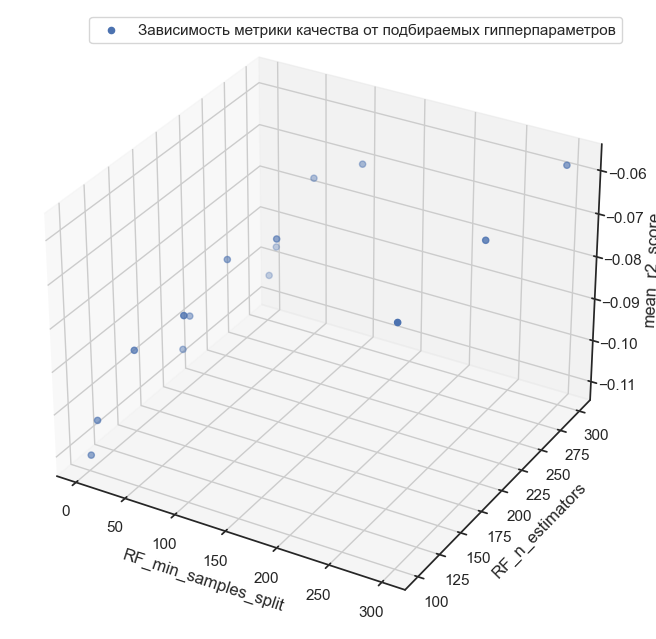

In [120]:
# прокладываем график зависимости метрики качества от подбираемых гипперпараметров
x_list = []
y_list = []

for i in range(15):
    x, y = RF.cv_results_['params'][i].values()
    
    x_list.append(x)
    y_list.append(y)
    
ax = plt.figure(figsize=(8,10)).add_subplot(projection='3d')
ax.scatter(x_list, y_list, RF.cv_results_['mean_test_score'], label='Зависимость метрики качества от подбираемых гипперпараметров')

# for i, j, k in zip(x_list, y_list, RF.cv_results_['mean_test_score']):
    # text = str(i) + ', ' + str(j) + ', ' + str(round(k, 2))
    # ax.text(i, j+0.01, k+0.005, text)

plt.xlabel('RF_min_samples_split')
plt.ylabel('RF_n_estimators')
# ax.set_xticks([0, 1, 2, 3])
# ax.set_xticklabels(['absolute_error', 'friedman_mse', 'poisson', 'squared_error'])
ax.set_zlabel('mean_r2_score')
ax.legend()
plt.show()

In [121]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров
RF.best_estimator_.fit(X_train_proc, y_train_proc_)
RF_predict_train_ = RF.best_estimator_.predict(X_train_proc)
RF_predict_test_ = RF.best_estimator_.predict(X_test_proc)

In [122]:
# Качество модели по метрике r2_score после подбора гиперпараметров
r2_score(y_train_proc, RF_predict_train_), r2_score(y_test_proc, RF_predict_test_)

(0.044542447719508105, -0.006782934817679109)

In [123]:
RF_predict_train_ = RF_predict_train_.reshape(-1, 1)
RF_predict_test_ = RF_predict_test_.reshape(-1, 1)

In [124]:
# дестандартизация и денормализация предсказаных значений  
RF_predict_train = pt_y_train.inverse_transform(RF_predict_train_)
RF_predict_test = pt_y_test.inverse_transform(RF_predict_test_)

In [125]:
# Качество модели по метрике mean_squared_error после подбора гиперпараметров
mean_squared_error(y_train, RF_predict_train), mean_squared_error(y_test, RF_predict_test)

(9.511320884362696, 9.233377403889527)

In [126]:
# Качество модели по метрике mean_absolute_error после подбора гиперпараметров
mean_absolute_error(y_train, RF_predict_train), mean_absolute_error(y_test, RF_predict_test)

(2.463664812602369, 2.44250539780125)

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

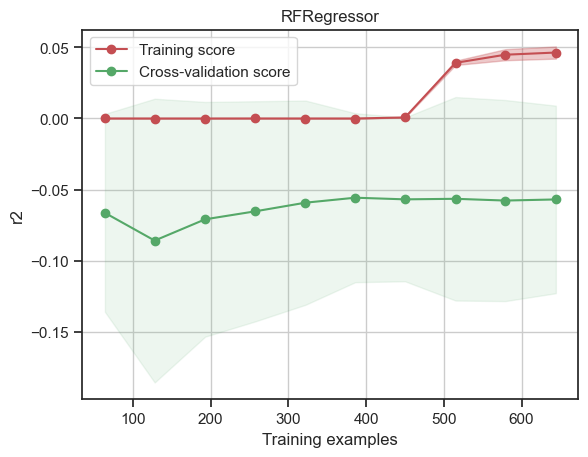

In [127]:
# Построение кривой обучения (зависимость качества модели от размера обучающей выборки)
plot_learning_curve(RF.best_estimator_, 'RFRegressor', 
                    X_train_proc, y_train_proc_, cv=10, train_sizes=np.linspace(.1, 1.0, 10))

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

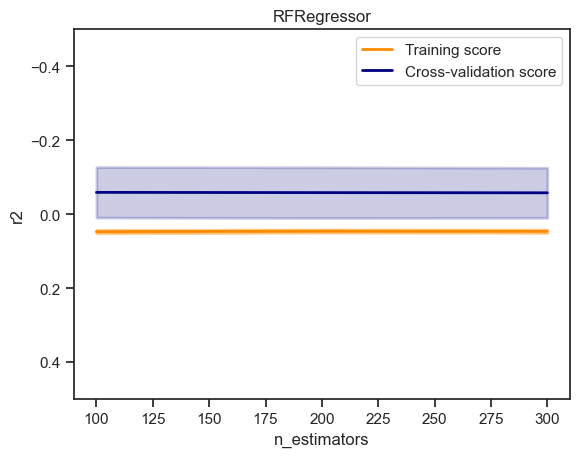

In [128]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(RF.best_estimator_, 'RFRegressor', 
                      X_train_proc, y_train_proc_, 
                      param_name='n_estimators', param_range = RF_n_estimators, 
                      cv=10, scoring="r2")

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

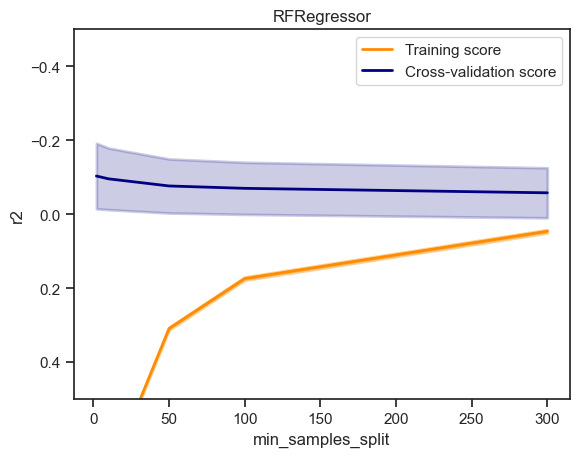

In [129]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(RF.best_estimator_, 'RFRegressor', 
                      X_train_proc, y_train_proc_, 
                      param_name='min_samples_split', param_range = RF_min_samples_split, 
                      cv=10, scoring="r2")

## 3. Сравнение полученных результатов

Соберем полученные метрики качества всех моделей в сводную таблицу для наглядности сравнения (будем оценивать по коэффициенту детерминации и МАЕ). 

In [130]:
# создаем словарь со значениями метрик
table = {'Models' : ['Linear', 'Lasso', 'ElasticNet', 'Ridge', 'SVR', 'KNeighbors', 'DecisionTree', 'GradBoosting','RanForest'
                    ],

'R_2_train' : [r2_score(y_train_proc, lin_reg_tuned_predict_train_), r2_score(y_train_proc, Lasso_tuned_predict_train_), 
               r2_score(y_train_proc, el_net_predict_train_),
               r2_score(y_train_proc, ridge_predict_train_), r2_score(y_train_proc, svr_2_predict_train_), r2_score(y_train_proc, knn_predict_train_),
               r2_score(y_train, tree_predict_train), r2_score(y_train_proc, GB_predict_train_), r2_score(y_train_proc, RF_predict_train_)
              ],

'R_2_test' : [r2_score(y_test_proc, lin_reg_tuned_predict_test_), r2_score(y_test_proc, Lasso_tuned_predict_test_), 
              r2_score(y_test_proc, el_net_predict_test_),
              r2_score(y_test_proc, ridge_predict_test_), r2_score(y_test_proc, svr_2_predict_test_), r2_score(y_test_proc, knn_predict_test_),
              r2_score(y_test, tree_predict_test), r2_score(y_test_proc, GB_predict_test_), r2_score(y_test_proc, RF_predict_test_)
             ]
        }

In [131]:
# получаем датафрейм из словаря
table_df = pd.DataFrame(data = table)
# cортируем 
comp_table = table_df.sort_values(by=['R_2_test'], ascending=False)
index_tab = range(1, 10)
comp_table = comp_table.set_axis(index_tab, axis='index')
comp_table

,Models,R_2_train,R_2_test
1,GradBoosting,0.091359,0.000340
2,Lasso,0.000000,0.000000
3,ElasticNet,0.000000,0.000000
4,Ridge,0.009134,-0.000063
5,RanForest,0.044542,-0.006783
6,Linear,0.012646,-0.007832
7,DecisionTree,0.030792,-0.011902
8,SVR,0.013847,-0.051856
9,KNeighbors,0.087681,-0.153480


In [132]:
# создаем словарь со значениями метрик
table_ = {'Models' : ['Linear', 'Lasso', 'ElasticNet', 'Ridge', 'SVR', 'KNeighbors', 'DecisionTree', 'GradBoosting','RanForest'
                    ],

'MAE_train' : [mean_absolute_error(y_train, lin_reg_tuned_predict_train), mean_absolute_error(y_train, Lasso_tuned_predict_train),
               mean_absolute_error(y_train, el_net_predict_train), mean_absolute_error(y_train, ridge_predict_train),
                 mean_absolute_error(y_train, svr_2_predict_train), mean_absolute_error(y_train, knn_predict_train),
                mean_absolute_error(y_train, tree_predict_train), mean_absolute_error(y_train, GB_predict_train),
               mean_absolute_error(y_train, RF_predict_train)
              ],

'MAE_test' : [mean_absolute_error(y_test, lin_reg_tuned_predict_test), mean_absolute_error(y_test, Lasso_tuned_predict_test),
              mean_absolute_error(y_test, el_net_predict_test),
                mean_absolute_error(y_test, ridge_predict_test), mean_absolute_error(y_test, svr_2_predict_test),
             mean_absolute_error(y_test, knn_predict_test), mean_absolute_error(y_test, tree_predict_test),
              mean_absolute_error(y_test, GB_predict_test), mean_absolute_error(y_test, RF_predict_test)
             ]
        }

In [133]:
# получаем датафрейм из словаря
table_df_ = pd.DataFrame(data = table_)
# cортируем 
comp_table_MAE = table_df_.sort_values(by=['MAE_test'], ascending=True)
index_tab_ = range(1, 10)
comp_table_MAE = comp_table_MAE.set_axis(index_tab_, axis='index')
comp_table_MAE

,Models,MAE_train,MAE_test
1,GradBoosting,2.400945,2.424237
2,Lasso,2.529395,2.436489
3,ElasticNet,2.529395,2.436489
4,DecisionTree,2.491782,2.437011
5,Ridge,2.515328,2.437801
6,RanForest,2.463665,2.442505
7,Linear,2.509523,2.442860
8,SVR,2.473953,2.494010
9,KNeighbors,2.408048,2.591990


In [135]:
# создаем словарь со значениями метрик
table__ = {'Models' : ['Linear', 'Lasso', 'ElasticNet', 'Ridge', 'SVR', 'KNeighbors', 'DecisionTree', 'GradBoosting','RanForest'
                    ],

'MSE_train' : [mean_squared_error(y_train, lin_reg_tuned_predict_train), mean_squared_error(y_train, Lasso_tuned_predict_train),
               mean_squared_error(y_train, el_net_predict_train), mean_squared_error(y_train, ridge_predict_train),
                 mean_squared_error(y_train, svr_2_predict_train), mean_squared_error(y_train, knn_predict_train),
                mean_squared_error(y_train, tree_predict_train), mean_squared_error(y_train, GB_predict_train),
               mean_squared_error(y_train, RF_predict_train)
              ],

'MSE_test' : [mean_squared_error(y_test, lin_reg_tuned_predict_test), mean_squared_error(y_test, Lasso_tuned_predict_test),
              mean_squared_error(y_test, el_net_predict_test),
                mean_squared_error(y_test, ridge_predict_test), mean_squared_error(y_test, svr_2_predict_test),
             mean_squared_error(y_test, knn_predict_test), mean_squared_error(y_test, tree_predict_test),
              mean_squared_error(y_test, GB_predict_test), mean_squared_error(y_test, RF_predict_test)
             ]
        }

In [136]:
# получаем датафрейм из словаря
table_df__ = pd.DataFrame(data = table__)
# cортируем 
comp_table_MSE = table_df__.sort_values(by=['MSE_test'], ascending=True)
index_tab__ = range(1, 10)
comp_table_MSE = comp_table_MSE.set_axis(index_tab__, axis='index')
comp_table_MSE

,Models,MSE_train,MSE_test
1,GradBoosting,9.050659,9.172272
2,Ridge,9.862851,9.174829
3,Lasso,9.953693,9.177602
4,ElasticNet,9.953693,9.177602
5,RanForest,9.511321,9.233377
6,Linear,9.828035,9.244718
7,DecisionTree,9.642457,9.281068
8,SVR,9.804956,9.619021
9,KNeighbors,9.089734,10.570756


#### ВЫВОД: Как видно из таблиц выше, модель 'GradientBoostingRegressor' показывает лучший результат.